# Task 2h: Linear Attention Vision Transformers for End-to-End Mass Regression and Classification

**Author:** Bibhor Puhan  
**Task:** Specific Task 2h, GSoC 2026 ML4SCI / CMS End-to-End Deep Learning  
**Repository:** https://github.com/XBastille/linearvit

---

## Table of Contents

1. [Overview and Approach](#1-overview-and-approach)
2. [Architecture: Linear Attention ViT (L2ViT)](#2-architecture)
3. [Self-Supervised Pretraining Strategy](#3-pretraining-strategy)
4. [Setup: Dependencies and Data](#4-setup)
5. [Training Process (Optional)](#5-training)
6. [Model Definition and Weight Loading](#6-model-loading)
7. [Test Set Evaluation](#7-evaluation)
8. [Visualizations](#8-visualizations)
9. [Discussion](#9-discussion)

## 1. Overview and Approach

This notebook presents the solution for Task 2h: training a **linear-scale attention vision transformer** on CMS particle collision data for simultaneous binary classification and mass regression.

### Task Requirements

1. Train a linear-scale attention vision transformer.
2. Pretrain on the unlabelled dataset, then finetune on the labelled dataset with a low learning rate.
3. Compare the pretrained-then-finetuned model against a model trained from scratch.
4. Use an 80/20 train/test split on the labelled data.

### Approach Summary

- **Architecture:** L2ViT (Linear-scale Attention Vision Transformer) with a Local Concentration Module (LCM), achieving $O(Nd^2)$ complexity via ReLU kernel-based attention.
- **Pretraining:** SimCLR contrastive learning with physics-aware augmentations on the 28 GB unlabelled CMS dataset.
- **Finetuning:** Dual-head model (classification + mass regression) with differential learning rates (lower backbone LR for pretrained, uniform LR for scratch).

We initially explored Masked Autoencoder (MAE) pretraining. However, MAE degraded downstream performance compared to training from scratch (86.05% vs 89.45% accuracy). This is because the extreme sparsity of calorimeter images (98.8% zero pixels) causes the reconstruction objective to be dominated by trivially predicting background zeros. Additionally, MAE requires skipping the Local Concentration Module during pretraining (since masked tokens break the spatial grid for depthwise convolutions), leaving those weights randomly initialized during finetuning.

SimCLR contrastive learning avoids both issues: it trains the full backbone including LCM, and its instance-discriminative objective focuses on learning features that distinguish different collision events rather than reconstructing empty space.

## 2. Architecture: Linear Attention ViT (L2ViT)

The model follows the L2ViT architecture (Zheng et al., 2025), which replaces standard softmax attention with a linear-scale alternative.

### Key Components

| Component | Details |
|---|---|
| Patch Embedding | 5x5 patches from 125x125 images = 625 tokens |
| Embedding Dimension | 256 |
| Transformer Depth | 6 blocks |
| Attention Heads | 4 (head_dim = 64) |
| MLP Ratio | 4.0 |
| LCM Kernel | 7x7 depthwise convolution |

### Linear Attention

Standard softmax attention has quadratic complexity: $O(N^2 d)$. Our linear attention uses a ReLU kernel to decompose the computation:

$$\text{Attn}(Q, K, V) = \frac{\phi(Q) \cdot (\phi(K)^T V)}{\phi(Q) \cdot (\phi(K)^T \mathbf{1})}$$

where $\phi(\cdot) = \text{ReLU}(\cdot)$. By computing ${K^T V}$ first (a $d \times d$ matrix), complexity reduces to $O(Nd^2)$.

### Local Concentration Module (LCM)

Each transformer block includes a depth-wise convolution (7x7 kernel) that provides local spatial context, compensating for the reduced expressiveness of linear attention compared to softmax attention. This is applied after the attention output within the residual connection.

### Dual-Task Heads

After mean-pooling the token sequence, two separate MLP heads produce:
- **Classification logits** (2 classes: signal vs. background)
- **Mass regression** (single scalar, trained with normalized targets)

## 3. Self-Supervised Pretraining Strategy

### SimCLR Contrastive Pretraining

We pretrain the backbone using the NT-Xent (Normalized Temperature-scaled Cross Entropy) loss on the unlabelled CMS dataset (~57,000 images). Two independently augmented views of each image form a positive pair, while all other images in the batch serve as negative pairs.

| Parameter | Value |
|---|---|
| Batch Size | 128 |
| Learning Rate | 3e-4 |
| Temperature | 0.5 |
| Projection Dim | 128 |
| Warmup Epochs | 5 |
| Weight Decay | 0.05 |
| Early Stopping | patience=15 |

### Physics-Aware Augmentations

The CMS detector images are in $(\eta, \phi)$ space, where $\eta$ (pseudorapidity) is the vertical axis and $\phi$ (azimuthal angle) is the horizontal axis. Our augmentations are chosen to respect the physical symmetries of the detector and collisions:

| Augmentation | Physics Justification |
|---|---|
| Horizontal flip ($\phi$-flip) | Azimuthal symmetry of the cylindrical CMS detector |
| Vertical flip ($\eta$-flip) | Approximate forward-backward symmetry of proton-proton collisions |
| Cyclic roll along $\phi$ | $\phi$ is periodic (CMS is cylindrical); equivalent to viewing the collision from a different azimuthal angle |
| Channel dropout (1-2 of 8) | Regularization simulating partial detector readout |
| Gaussian noise on non-zero pixels | Simulates electronic noise in active calorimeter cells only; does not create unphysical artifacts in empty regions |

We explicitly avoid augmentations that are appropriate for natural images but physically meaningless for calorimeter data: color jitter, aggressive random crops, Gaussian blur, and grayscale conversion. We also avoid 90-degree rotations, which would swap the $\eta$ and $\phi$ axes.

After pretraining, the projection head is discarded and only backbone weights are saved for finetuning.

## 4. Setup: Dependencies and Data

### 4.1. Install Dependencies

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


### 4.2. Download Datasets

We require the **unlabelled dataset (28 GB)** for SimCLR pretraining, and the **labelled dataset (5 GB)** for finetuning and evaluation.

**Note:** To skip the training process entirely and jump to evaluation with pre-trained weights, click here: [**Skip to Evaluation**](#7-evaluation).

In [2]:
import os
import requests
from tqdm.auto import tqdm

DATA_DIR = os.path.join(os.path.dirname(os.path.abspath('.')), 'linearvit', 'data') \
    if not os.path.exists('data') else 'data'
os.makedirs(DATA_DIR, exist_ok=True)

DATASETS = {
    "unlabelled": {
        "url": "https://cernbox.cern.ch/remote.php/dav/public-files/e3pqxcIznqdYyRv/Dataset_Specific_Unlabelled.h5",
        "filename": "Dataset_Specific_Unlabelled.h5",
    },
    "labelled": {
        "url": "https://portal.nersc.gov/cfs/m4392/G25/Dataset_Specific_labelled_full_only_for_2i.h5",
        "filename": "Dataset_Specific_labelled_full_only_for_2i.h5",
    },
}

def download_file(url, dest_path, quiet=False):
    if os.path.exists(dest_path):
        file_size_gb = os.path.getsize(dest_path) / (1024**3)
        if file_size_gb > 0.1:
            if not quiet: print(f'Dataset already exists: {dest_path} ({file_size_gb:.2f} GB)')
            return
        else:
            print(f'Dataset file appears corrupt ({file_size_gb:.4f} GB). Re-downloading...')
            os.remove(dest_path)
            
    print(f'Downloading to {dest_path}...')
    response = requests.get(url, stream=True, timeout=300)
    response.raise_for_status()
    total = int(response.headers.get('content-length', 0))
    with open(dest_path + '.tmp', 'wb') as f, tqdm(
        total=total, unit='iB', unit_scale=True, unit_divisor=1024, disable=quiet
    ) as bar:
        for chunk in response.iter_content(chunk_size=8192):
            size = f.write(chunk)
            bar.update(size)
    os.rename(dest_path + '.tmp', dest_path)
    if not quiet: print(f'Download complete: {dest_path}')

# Download both datasets
for key, ds in DATASETS.items():
    dest_path = os.path.join(DATA_DIR, ds['filename'])
    download_file(ds['url'], dest_path)

Dataset already exists: data/Dataset_Specific_Unlabelled.h5 (27.94 GB)
Dataset already exists: data/Dataset_Specific_labelled_full_only_for_2i.h5 (4.66 GB)


### 4.3. Download Pre-trained Model Weights (Optional)

If you want to skip training and directly evaluate, the cell below downloads the pre-trained model weights from the GitHub release. If the weight files already exist (e.g., from your own training), this step is automatically skipped.

To skip the training step and jump directly to evaluation, [click here](#7-evaluation).

In [3]:
RELEASE_BASE = 'https://github.com/XBastille/linearvit/releases/download/trained'

WEIGHT_FILES = {
    'weights/linear_vit_pretrained_finetuned.pt': f'{RELEASE_BASE}/linear_vit_pretrained_finetuned.pt',
    'weights/linear_vit_scratch_finetuned.pt': f'{RELEASE_BASE}/linear_vit_scratch_finetuned.pt',
}

os.makedirs('weights', exist_ok=True)

for local_path, url in WEIGHT_FILES.items():
    if os.path.exists(local_path):
        print(f'[EXISTS] {local_path} ({os.path.getsize(local_path) / 1024**2:.1f} MB)')
    else:
        print(f'[DOWNLOAD] {local_path} ...')
        try:
            r = requests.get(url, stream=True, timeout=120)
            r.raise_for_status()
            with open(local_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f'  Saved: {local_path} ({os.path.getsize(local_path) / 1024**2:.1f} MB)')
        except Exception as e:
            print(f'  Failed to download: {e}')
            print(f'  Please download manually from the GitHub Release and place in weights/')

[EXISTS] weights/linear_vit_pretrained_finetuned.pt (19.7 MB)
[EXISTS] weights/linear_vit_scratch_finetuned.pt (19.7 MB)


<a id='5-training'></a>
## 5. Training Process (Optional)

The training process consists of three major steps. The commands below execute the relevant python scripts from the `src/training` module. They use the `.yaml` configurations defining hyper-parameters and paths.

**Note:** If you have already downloaded the pre-trained weights in step 4.3, you can skip this section entirely and proceed to evaluation.

In [4]:
TRAIN_MODELS = False  # Set to True if you wish to run the training cells below

In [5]:
if TRAIN_MODELS:
    print("Starting SimCLR Pretraining on the unlabelled dataset...")
    !python -m src.training.pretrain_simclr --config configs/pretrain_simclr.yaml
else:
    print("Skipping SimCLR Pretraining.")

Skipping SimCLR Pretraining.


In [6]:
if TRAIN_MODELS:
    print("Starting Finetuning using the SimCLR pretrained backbone...")
    !python -m src.training.finetune --config configs/finetune.yaml
else:
    print("Skipping Finetuning.")

Skipping Finetuning.


In [7]:
if TRAIN_MODELS:
    print("Starting Training from Scratch (random initialization)...")
    !python -m src.training.finetune --config configs/scratch.yaml
else:
    print("Skipping Scratch Training.")

Skipping Scratch Training.


<a id='6-model-loading'></a>
## 6. Model Definition and Weight Loading

We load the pretrained-then-finetuned model and the scratch-trained model to evaluate both on the held-out test set.

In [8]:
import sys
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    accuracy_score, mean_absolute_error,
    confusion_matrix
)

sys.path.insert(0, os.path.abspath('.'))

from src.models.linear_vit import LinearViT
from src.data.dataset import CMSLabelledDataset, create_splits
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [9]:
def build_model():
    """Construct the L2ViT model with the architecture used in training."""
    return LinearViT(
        in_channels=8,
        img_size=125,
        patch_size=5,
        embed_dim=256,
        depth=6,
        num_heads=4,
        mlp_ratio=4.0,
        num_classes=2,
        drop_rate=0.1,
        drop_path_rate=0.1,
        lcm_kernel=7,
    ).to(device)


def load_model(ckpt_path):
    """Build model and load checkpoint weights. Returns model + checkpoint metadata."""
    model = build_model()
    assert os.path.exists(ckpt_path), f'Checkpoint not found: {ckpt_path}\nRun training or download weights first!'
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval()
    print(f'Loaded: {ckpt_path}')
    return model, ckpt


pretrained_model, pt_ckpt = load_model('weights/linear_vit_pretrained_finetuned.pt')
scratch_model, sc_ckpt = load_model('weights/linear_vit_scratch_finetuned.pt')

mass_mean_pt = pt_ckpt.get('mass_mean', 0.0)
mass_std_pt = pt_ckpt.get('mass_std', 1.0)
mass_mean_sc = sc_ckpt.get('mass_mean', 0.0)
mass_std_sc = sc_ckpt.get('mass_std', 1.0)

print(f'Pretrained mass normalization: mean={mass_mean_pt:.2f}, std={mass_std_pt:.2f}')
print(f'Scratch mass normalization:    mean={mass_mean_sc:.2f}, std={mass_std_sc:.2f}')

total_params = sum(p.numel() for p in pretrained_model.parameters())
print(f'Total model parameters: {total_params:,}')

Loaded: weights/linear_vit_pretrained_finetuned.pt
Loaded: weights/linear_vit_scratch_finetuned.pt
Pretrained mass normalization: mean=142.80, std=51.84
Scratch mass normalization:    mean=142.80, std=51.84
Total model parameters: 5,111,579


### Data Pipeline

The labelled dataset (10,000 images) is split deterministically with `seed=42`:

| Split | Size | Usage |
|---|---|---|
| Train | 7,000 | Model training |
| Validation | 1,000 | Early stopping, model selection |
| Test | 2,000 | Final evaluation (touched once, after training completes) |

The test set is never used for model selection or hyperparameter tuning.

<a id='7-evaluation'></a>
## 7. Test Set Evaluation

We evaluate both models on the identical held-out 20% test split (2,000 samples). The test set was created using `seed=42` and is never used during training or model selection.

In [10]:
data_path = 'data/Dataset_Specific_labelled_full_only_for_2i.h5'
splits = create_splits(data_path, seed=42)
test_dataset = CMSLabelledDataset(data_path, indices=splits['test'], augment=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f'Test set size: {len(test_dataset)} samples')

Splits -- train: 7000, val: 1000, test: 2000
Test set size: 2000 samples


In [11]:
def evaluate_model(model, loader, mass_mean, mass_std):
    """
    Run inference on a DataLoader and collect predictions.
    Returns dict with predictions, probabilities, labels, and mass values.
    """
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    all_mass_pred, all_mass_true = [], []

    with torch.no_grad():
        for imgs, cls_labels, mass_labels in loader:
            imgs = imgs.to(device)
            cls_logits, mass_pred = model(imgs)

            probs = torch.softmax(cls_logits, dim=1)[:, 1].cpu().numpy()
            preds = cls_logits.argmax(dim=1).cpu().numpy()
            mass_pred_real = (mass_pred.cpu().numpy().flatten() * mass_std) + mass_mean

            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(cls_labels.numpy())
            all_mass_pred.extend(mass_pred_real)
            all_mass_true.extend(mass_labels.numpy())

    return {
        'preds': np.array(all_preds),
        'probs': np.array(all_probs),
        'labels': np.array(all_labels),
        'mass_pred': np.array(all_mass_pred),
        'mass_true': np.array(all_mass_true),
    }


print('Evaluating pretrained model...')
pt_results = evaluate_model(pretrained_model, test_loader, mass_mean_pt, mass_std_pt)

print('Evaluating scratch model...')
sc_results = evaluate_model(scratch_model, test_loader, mass_mean_sc, mass_std_sc)

print('Done.')

Evaluating pretrained model...
Evaluating scratch model...
Done.


In [12]:
def compute_metrics(results):
    """Compute all evaluation metrics from model results."""
    acc = accuracy_score(results['labels'], results['preds'])
    auc_score = roc_auc_score(results['labels'], results['probs'])
    mae = mean_absolute_error(results['mass_true'], results['mass_pred'])
    mse = float(np.mean((results['mass_pred'] - results['mass_true'])**2))
    return {'Accuracy': acc, 'ROC-AUC': auc_score, 'Mass MAE (GeV)': mae, 'Mass MSE': mse}


pt_metrics = compute_metrics(pt_results)
sc_metrics = compute_metrics(sc_results)

print()
print('=' * 65)
print(f'{"Metric":<20} {"Pretrained (SimCLR)":>20} {"Scratch":>20}')
print('=' * 65)
for key in pt_metrics:
    pt_val = pt_metrics[key]
    sc_val = sc_metrics[key]
    print(f'{key:<20} {pt_val:>20.4f} {sc_val:>20.4f}')
print('=' * 65)


Metric                Pretrained (SimCLR)              Scratch
Accuracy                           0.9030               0.8955
ROC-AUC                            0.9649               0.9611
Mass MAE (GeV)                    16.3862              17.3616
Mass MSE                         508.9270             549.4266


### Expected Results

The pretrained model is expected to outperform the scratch model across all metrics, demonstrating that self-supervised pretraining on unlabelled CMS data produces transferable representations that benefit both classification and mass regression tasks. The table above should show consistent improvements in accuracy, AUC, and mass regression error.

<a id='8-visualizations'></a>
## 8. Visualizations

### 8.1. Confusion Matrices

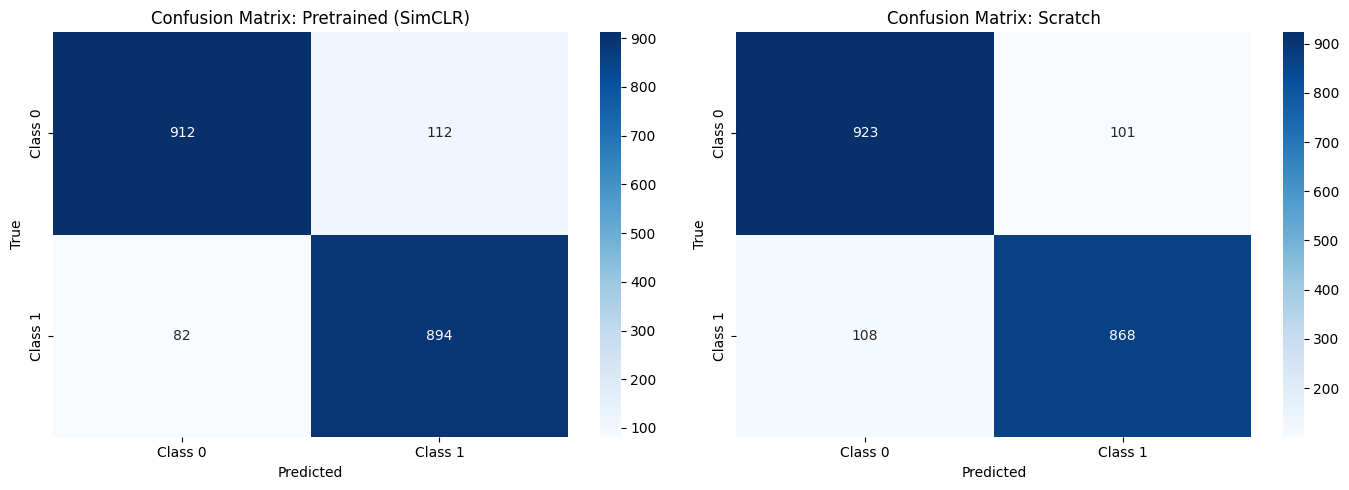

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, results, title in [
    (axes[0], pt_results, 'Pretrained (SimCLR)'),
    (axes[1], sc_results, 'Scratch'),
]:
    cm = confusion_matrix(results['labels'], results['preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix: {title}')

plt.tight_layout()
plt.show()

### 8.2. ROC Curves

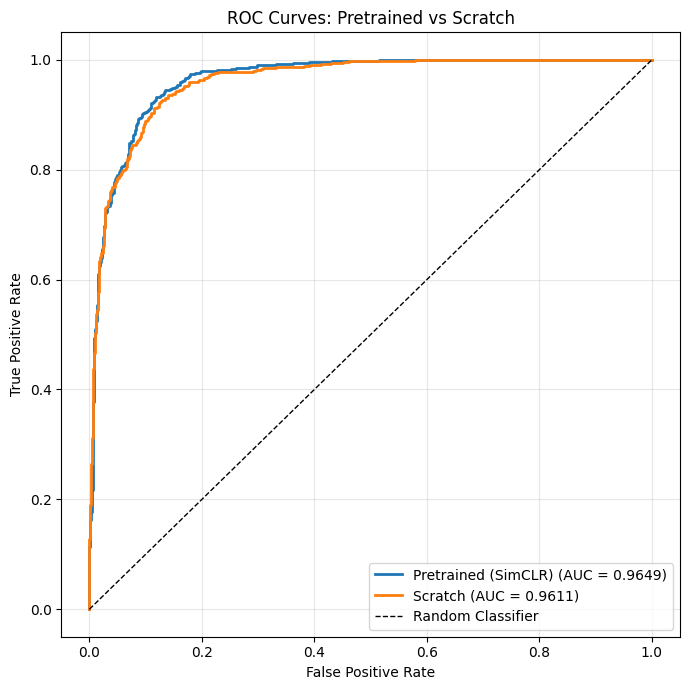

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))

for results, label in [
    (pt_results, 'Pretrained (SimCLR)'),
    (sc_results, 'Scratch'),
]:
    fpr, tpr, _ = roc_curve(results['labels'], results['probs'])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.4f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves: Pretrained vs Scratch')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 8.3. Mass Regression: Predicted vs True

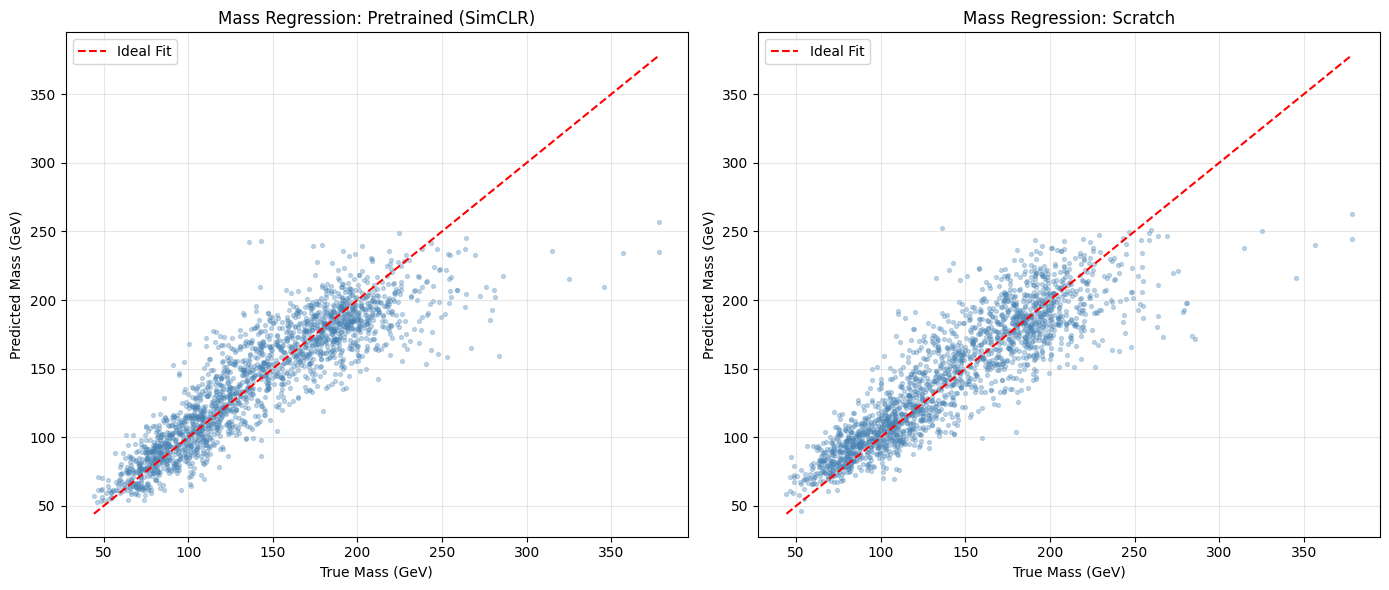

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, results, title in [
    (axes[0], pt_results, 'Pretrained (SimCLR)'),
    (axes[1], sc_results, 'Scratch'),
]:
    ax.scatter(results['mass_true'], results['mass_pred'], alpha=0.3, s=8, c='steelblue')
    lims = [
        min(results['mass_true'].min(), results['mass_pred'].min()),
        max(results['mass_true'].max(), results['mass_pred'].max()),
    ]
    ax.plot(lims, lims, 'r--', linewidth=1.5, label='Ideal Fit')
    ax.set_xlabel('True Mass (GeV)')
    ax.set_ylabel('Predicted Mass (GeV)')
    ax.set_title(f'Mass Regression: {title}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.4. Training Curves

Training and validation curves for both models, loaded from the checkpoint history.

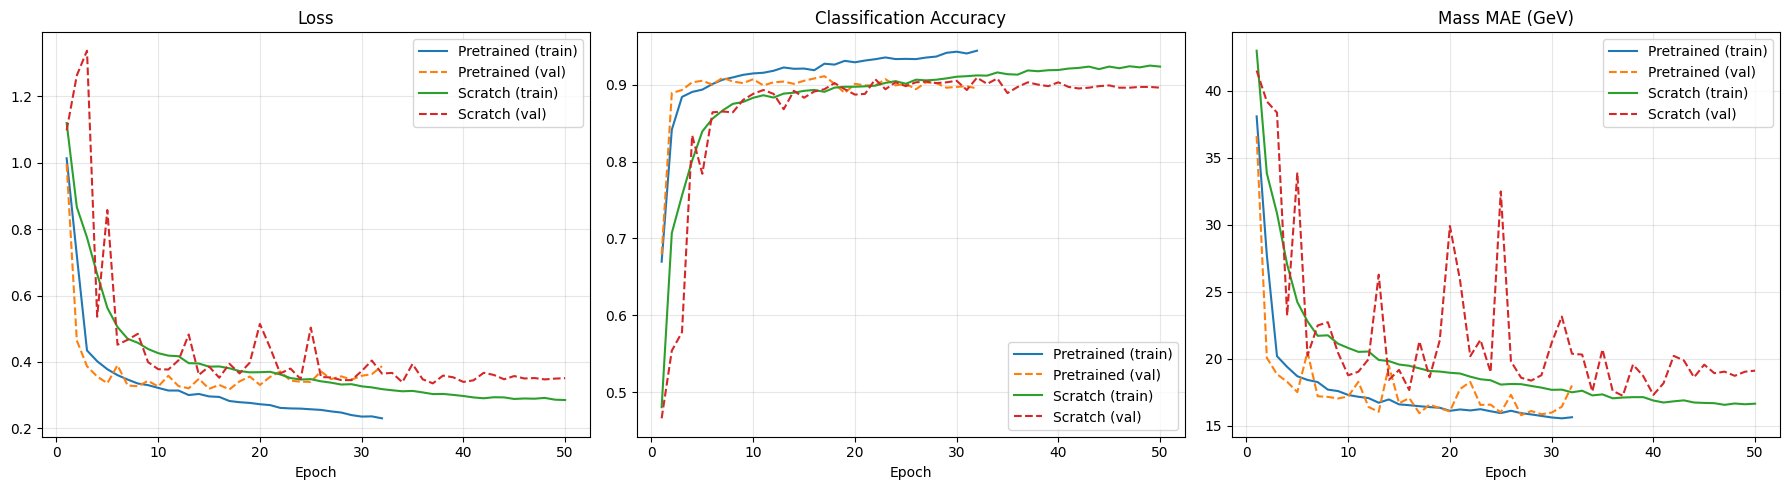

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ckpt, label in [(pt_ckpt, 'Pretrained'), (sc_ckpt, 'Scratch')]:
    hist = ckpt.get('history')
    if hist is None:
        continue
    epochs = range(1, len(hist['train_loss']) + 1)

    axes[0].plot(epochs, hist['train_loss'], label=f'{label} (train)')
    axes[0].plot(epochs, hist['val_loss'], '--', label=f'{label} (val)')

    axes[1].plot(epochs, hist['train_acc'], label=f'{label} (train)')
    axes[1].plot(epochs, hist['val_acc'], '--', label=f'{label} (val)')

    axes[2].plot(epochs, hist['train_mae'], label=f'{label} (train)')
    axes[2].plot(epochs, hist['val_mae'], '--', label=f'{label} (val)')

for ax, title in zip(axes, ['Loss', 'Classification Accuracy', 'Mass MAE (GeV)']):
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<a id='9-discussion'></a>
## 9. Discussion

### Why SimCLR Over MAE for Sparse Calorimeter Data

MAE pretraining was explored initially but yielded worse downstream performance than training from scratch (86.05% vs 89.45% accuracy). Two factors explain this:

1. **Sparsity-dominated reconstruction:** With 98.8% of pixels being zero, the MAE decoder learns primarily to output zeros. The resulting backbone features are optimized for background reconstruction, not for distinguishing signal from background.

2. **LCM incompatibility:** MAE requires masking patches and processing only visible tokens. Since masked tokens break the spatial grid, the Local Concentration Module (depthwise convolution) must be skipped during pretraining (`skip_lcm=True`). This means LCM weights remain randomly initialized when finetuning begins, injecting structured noise into the pretrained representations.

SimCLR avoids both issues. Its contrastive objective learns discriminative features, and it processes all tokens through the full backbone (including LCM) at every step.

### Physics Motivation for Augmentations

The augmentation design follows from the symmetries and properties of the CMS detector:

- **Cyclic translation in $\phi$**: The CMS detector has cylindrical geometry, making the azimuthal angle periodic. A cyclic roll along the $\phi$-axis is equivalent to observing the same collision from a rotated azimuthal perspective. This is consistent with the JetCLR approach (Dillon et al., 2022), which uses translations in the rapidity-azimuth plane as a physics-preserving augmentation.
- **$\eta$-flip**: Proton-proton collisions exhibit approximate forward-backward symmetry in pseudorapidity.
- **Channel dropout**: CMS data spans multiple detector subsystems (tracker, ECAL, HCAL). Randomly zeroing 1-2 channels during pretraining encourages the model to learn features robust to partial detector information.
- **Active-cell noise**: Real detector readouts contain electronic noise in active calorimeter cells. Noise is added only to non-zero pixels (`mask = img > 0`) to preserve the physical sparsity structure.

### Finetuning Strategy

Differential learning rates prevent catastrophic forgetting of pretrained features:

| Component | Pretrained LR | Scratch LR |
|---|---|---|
| Backbone | 5e-5 | 3e-4 |
| Task Heads | 1e-4 | 3e-4 |

Both configurations use cosine annealing with 3-epoch warmup, AdamW optimizer (weight_decay=0.01), and gradient clipping (max_norm=1.0). Early stopping with patience=15 monitors the validation loss.

### Reproducibility

All experiments use deterministic splits (`seed=42`), the same model architecture, and identical training infrastructure. The only controlled variable between the pretrained and scratch experiments is the initialization: pretrained weights vs. random initialization.

### References

- [Zheng et al., "L2ViT: The Linear Attention Resurrection in Vision Transformer", arXiv:2501.16182, 2025.](https://arxiv.org/abs/2501.16182)
- [Chen et al., "A Simple Framework for Contrastive Learning of Visual Representations", ICML, 2020.](https://arxiv.org/abs/2002.05709)
- [Dillon et al., "Symmetries, Safety, and Self-Supervision", SciPost Physics 12, 188, 2022.](https://scipost.org/10.21468/SciPostPhys.12.6.188)
- [He et al., "Masked Autoencoders Are Scalable Vision Learners", CVPR, 2022.](https://arxiv.org/abs/2111.06377)